In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Importing  the Librairies**

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [ ]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


### Load the data

In [ ]:
!unzip /content/drive/MyDrive/Dataset/new-plant-diseases-dataset.zip

### Prepare training and validation  dataset
Create the training and validation directories 

In [ ]:
data_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'valid')


In [ ]:
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"

In [ ]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train : 70295files
total images for validation : /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid : 17572files


### Setup Image shape and Batch size

In [ ]:
IMAGE_SHAPE = (224, 224)

BATCH_SIZE = 64 #@param {type:"integer"}

### Data Preprocessing

Set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. 

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).



In [ ]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)


Found 17572 images belonging to 38 classes.
Found 70295 images belonging to 38 classes.


### Build the model

In [ ]:

model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])


### Specify Loss Function and Optimizer

In [ ]:
LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Train Model

In [ ]:

EPOCHS=10

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/10
1098/1098 [==============================] - 1003s 908ms/step - loss: 0.7315 - accuracy: 0.7724 - val_loss: 0.3194 - val_accuracy: 0.8979
Epoch 2/10
1098/1098 [==============================] - 952s 867ms/step - loss: 0.4574 - accuracy: 0.8507 - val_loss: 0.2656 - val_accuracy: 0.9120
Epoch 3/10
1098/1098 [==============================] - 943s 859ms/step - loss: 0.4173 - accuracy: 0.8628 - val_loss: 0.2485 - val_accuracy: 0.9174
Epoch 4/10
1098/1098 [==============================] - 938s 854ms/step - loss: 0.3883 - accuracy: 0.8720 - val_loss: 0.2204 - val_accuracy: 0.9268
Epoch 5/10
1098/1098 [==============================] - 936s 853ms/step - loss: 0.3716 - accuracy: 0.8776 - val_loss: 0.2261 - val_accuracy: 0.9237
Epoch 6/10
1098/1098 [==============================] - 931s 848ms/step - loss: 0.3652 - accuracy: 0.8789 - val_loss: 0.2242 - val_accuracy: 0.9251
Epoch 7/10
1098/1098 [==============================] - 932s 849ms/step - loss: 0.3472 - accuracy: 0.8864 - val

### Check Performance
Plot training and validation accuracy and loss

### Random test
Random sample images from validation dataset and predict

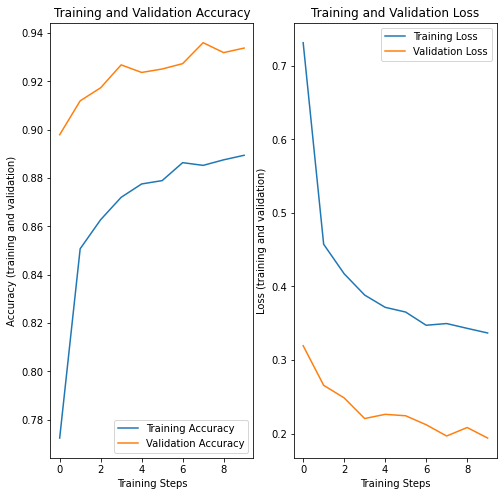

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [ ]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Corn_(maize)___Common_rust_, file: Corn_(maize)___Common_rust_/RS_Rust 2376.JPG
PREDICTED: class: Corn_(maize)___Common_rust_, confidence: 0.999716


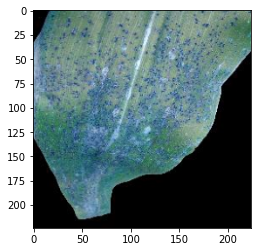

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___Spider_mites Two-spotted_spider_mite, file: Tomato___Spider_mites Two-spotted_spider_mite/0cee18fc-bbbd-40dd-8d73-93df072c09ea___Com.G_SpM_FL 8904.JPG
PREDICTED: class: Tomato___Spider_mites Two-spotted_spider_mite, confidence: 0.994170


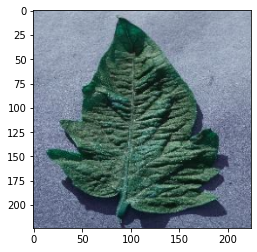

SOURCE: class: Apple___Apple_scab, file: Apple___Apple_scab/23f31e0d-3330-4752-9f83-8aba28c90ccb___FREC_Scab 3178_new30degFlipLR.JPG
PREDICTED: class: Apple___Apple_scab, confidence: 0.990728


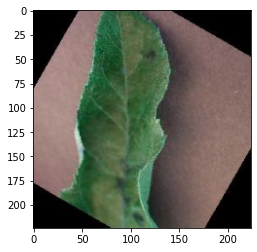

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___Target_Spot, file: Tomato___Target_Spot/bd944873-f589-4507-9bb2-e2ff8d024b9f___Com.G_TgS_FL 9884.JPG
PREDICTED: class: Tomato___Target_Spot, confidence: 0.901764


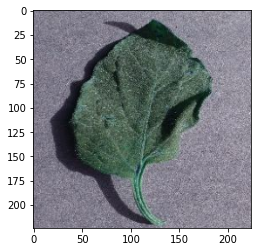

<Figure size 432x288 with 0 Axes>

SOURCE: class: Blueberry___healthy, file: Blueberry___healthy/fe0dd723-e1f1-4190-9936-175716ca6065___RS_HL 0678.JPG
PREDICTED: class: Blueberry___healthy, confidence: 0.989485


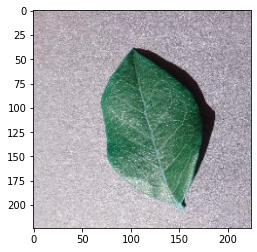

<Figure size 432x288 with 0 Axes>

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

## Export as saved model and convert to TFLite

In [ ]:
model.save('mobilenet.h5')

## Convert Model to TFLite

In [ ]:
# convert the model to TFLite
import tensorflow as tf
from tensorflow import lite
from tensorflow.keras.models import load_model
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open ("model.tflite" , "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmpkifje88n/assets


INFO:tensorflow:Assets written to: /tmp/tmpkifje88n/assets


11569084

In [ ]:
! cp mobilenet.tflite /content/drive/MyDrive